In [ ]:
                # from mimic_cxr_jpg_loader import MIMIC_CXR_JPG_Loader
import os
import gzip
import pandas as pd

data_folder = '../data/physionet.org/files/mimic-cxr-jpg/2.0.0/files'
csv_folder = '../data/physionet.org/files/mimic-cxr-jpg/2.0.0'
metadata_csv_file = 'mimic-cxr-2.0.0-metadata.csv.gz'
split_csv_file = 'mimic-cxr-2.0.0-split.csv.gz'
chexpert_csv_file = 'mimic-cxr-2.0.0-chexpert.csv.gz'

In [ ]:
# Read .csv info files
with gzip.open(os.path.join(csv_folder, chexpert_csv_file), 'rt') as file:
    label_csv = pd.read_csv(file)
with gzip.open(os.path.join(csv_folder, metadata_csv_file), 'rt') as file:
    metadata_csv = pd.read_csv(file)
with gzip.open(os.path.join(csv_folder, split_csv_file), 'rt') as file:
    split_csv = pd.read_csv(file)
    
# Merge the data
merged_data = pd.merge(metadata_csv, split_csv, on=['dicom_id', 'study_id', 'subject_id'])
grouped_data = merged_data.groupby('split', group_keys=False)
grouped_data.get_group('validate')

In [1]:
# coding=utf-8
# Copyright 2020 The SimCLR Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific simclr governing permissions and
# limitations under the License.
# ==============================================================================

"""Data preprocessing and augmentation."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import functools
from absl import flags

import tensorflow.compat.v1 as tf
# tf.enable_eager_execution()

FLAGS = flags.FLAGS

CROP_PROPORTION = 0.875  # Standard for ImageNet.


def random_apply(func, p, x):
  """Randomly apply function func to x with probability p."""
  return tf.cond(
      tf.less(tf.random_uniform([], minval=0, maxval=1, dtype=tf.float32),
              tf.cast(p, tf.float32)),
      lambda: func(x),
      lambda: x)


def random_brightness(image, max_delta, impl='simclrv2'):
  """A multiplicative vs additive change of brightness."""
  if impl == 'simclrv2':
    factor = tf.random_uniform(
        [], tf.maximum(1.0 - max_delta, 0), 1.0 + max_delta)
    image = image * factor
  elif impl == 'simclrv1':
    image = tf.image.random_brightness(image, max_delta=max_delta)
  else:
    raise ValueError('Unknown impl {} for random brightness.'.format(impl))
  return image


def to_grayscale(image, keep_channels=True):
  image = tf.image.rgb_to_grayscale(image)
  if keep_channels:
    image = tf.tile(image, [1, 1, 3])
  return image


def color_jitter(image, strength, random_order=True, impl='simclrv2'):
  """Distorts the color of the image.

  Args:
    image: The input image tensor.
    strength: the floating number for the strength of the color augmentation.
    random_order: A bool, specifying whether to randomize the jittering order.
    impl: 'simclrv1' or 'simclrv2'.  Whether to use simclrv1 or simclrv2's
        version of random brightness.

  Returns:
    The distorted image tensor.
  """
  brightness = 0.8 * strength
  contrast = 0.8 * strength
  saturation = 0.8 * strength
  hue = 0.2 * strength
  if random_order:
    return color_jitter_rand(
        image, brightness, contrast, saturation, hue, impl=impl)
  else:
    return color_jitter_nonrand(
        image, brightness, contrast, saturation, hue, impl=impl)


def color_jitter_nonrand(image,
                         brightness=0,
                         contrast=0,
                         saturation=0,
                         hue=0,
                         impl='simclrv2'):
  """Distorts the color of the image (jittering order is fixed).

  Args:
    image: The input image tensor.
    brightness: A float, specifying the brightness for color jitter.
    contrast: A float, specifying the contrast for color jitter.
    saturation: A float, specifying the saturation for color jitter.
    hue: A float, specifying the hue for color jitter.
    impl: 'simclrv1' or 'simclrv2'.  Whether to use simclrv1 or simclrv2's
        version of random brightness.

  Returns:
    The distorted image tensor.
  """
  with tf.name_scope('distort_color'):
    def apply_transform(i, x, brightness, contrast, saturation, hue):
      """Apply the i-th transformation."""
      if brightness != 0 and i == 0:
        x = random_brightness(x, max_delta=brightness, impl=impl)
      elif contrast != 0 and i == 1:
        x = tf.image.random_contrast(
            x, lower=1-contrast, upper=1+contrast)
      elif saturation != 0 and i == 2:
        x = tf.image.random_saturation(
            x, lower=1-saturation, upper=1+saturation)
      elif hue != 0:
        x = tf.image.random_hue(x, max_delta=hue)
      return x

    for i in range(4):
      image = apply_transform(i, image, brightness, contrast, saturation, hue)
      image = tf.clip_by_value(image, 0., 1.)
    return image


def color_jitter_rand(image,
                      brightness=0,
                      contrast=0,
                      saturation=0,
                      hue=0,
                      impl='simclrv2'):
  """Distorts the color of the image (jittering order is random).

  Args:
    image: The input image tensor.
    brightness: A float, specifying the brightness for color jitter.
    contrast: A float, specifying the contrast for color jitter.
    saturation: A float, specifying the saturation for color jitter.
    hue: A float, specifying the hue for color jitter.
    impl: 'simclrv1' or 'simclrv2'.  Whether to use simclrv1 or simclrv2's
        version of random brightness.

  Returns:
    The distorted image tensor.
  """
  with tf.name_scope('distort_color'):
    def apply_transform(i, x):
      """Apply the i-th transformation."""
      def brightness_foo():
        if brightness == 0:
          return x
        else:
          return random_brightness(x, max_delta=brightness, impl=impl)

      def contrast_foo():
        if contrast == 0:
          return x
        else:
          return tf.image.random_contrast(x, lower=1-contrast, upper=1+contrast)
      def saturation_foo():
        if saturation == 0:
          return x
        else:
          return tf.image.random_saturation(
              x, lower=1-saturation, upper=1+saturation)
      def hue_foo():
        if hue == 0:
          return x
        else:
          return tf.image.random_hue(x, max_delta=hue)
      x = tf.cond(tf.less(i, 2),
                  lambda: tf.cond(tf.less(i, 1), brightness_foo, contrast_foo),
                  lambda: tf.cond(tf.less(i, 3), saturation_foo, hue_foo))
      return x

    perm = tf.random_shuffle(tf.range(4))
    for i in range(4):
      image = apply_transform(perm[i], image)
      image = tf.clip_by_value(image, 0., 1.)
    return image


def _compute_crop_shape(
    image_height, image_width, aspect_ratio, crop_proportion):
  """Compute aspect ratio-preserving shape for central crop.

  The resulting shape retains `crop_proportion` along one side and a proportion
  less than or equal to `crop_proportion` along the other side.

  Args:
    image_height: Height of image to be cropped.
    image_width: Width of image to be cropped.
    aspect_ratio: Desired aspect ratio (width / height) of output.
    crop_proportion: Proportion of image to retain along the less-cropped side.

  Returns:
    crop_height: Height of image after cropping.
    crop_width: Width of image after cropping.
  """
  image_width_float = tf.cast(image_width, tf.float32)
  image_height_float = tf.cast(image_height, tf.float32)

  def _requested_aspect_ratio_wider_than_image():
    crop_height = tf.cast(tf.rint(
        crop_proportion / aspect_ratio * image_width_float), tf.int32)
    crop_width = tf.cast(tf.rint(
        crop_proportion * image_width_float), tf.int32)
    return crop_height, crop_width

  def _image_wider_than_requested_aspect_ratio():
    crop_height = tf.cast(
        tf.rint(crop_proportion * image_height_float), tf.int32)
    crop_width = tf.cast(tf.rint(
        crop_proportion * aspect_ratio *
        image_height_float), tf.int32)
    return crop_height, crop_width

  return tf.cond(
      aspect_ratio > image_width_float / image_height_float,
      _requested_aspect_ratio_wider_than_image,
      _image_wider_than_requested_aspect_ratio)


def center_crop(image, height, width, crop_proportion):
  """Crops to center of image and rescales to desired size.

  Args:
    image: Image Tensor to crop.
    height: Height of image to be cropped.
    width: Width of image to be cropped.
    crop_proportion: Proportion of image to retain along the less-cropped side.

  Returns:
    A `height` x `width` x channels Tensor holding a central crop of `image`.
  """
  shape = tf.shape(image)
  image_height = shape[0]
  image_width = shape[1]
  crop_height, crop_width = _compute_crop_shape(
      image_height, image_width, width / height, crop_proportion)
  offset_height = ((image_height - crop_height) + 1) // 2
  offset_width = ((image_width - crop_width) + 1) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_height, offset_width, crop_height, crop_width)

  image = tf.image.resize_bicubic([image], [height, width])[0]

  return image


def distorted_bounding_box_crop(image,
                                bbox,
                                min_object_covered=0.1,
                                aspect_ratio_range=(0.75, 1.33),
                                area_range=(0.05, 1.0),
                                max_attempts=100,
                                scope=None):
  """Generates cropped_image using one of the bboxes randomly distorted.

  See `tf.image.sample_distorted_bounding_box` for more documentation.

  Args:
    image: `Tensor` of image data.
    bbox: `Tensor` of bounding boxes arranged `[1, num_boxes, coords]`
        where each coordinate is [0, 1) and the coordinates are arranged
        as `[ymin, xmin, ymax, xmax]`. If num_boxes is 0 then use the whole
        image.
    min_object_covered: An optional `float`. Defaults to `0.1`. The cropped
        area of the image must contain at least this fraction of any bounding
        box supplied.
    aspect_ratio_range: An optional list of `float`s. The cropped area of the
        image must have an aspect ratio = width / height within this range.
    area_range: An optional list of `float`s. The cropped area of the image
        must contain a fraction of the supplied image within in this range.
    max_attempts: An optional `int`. Number of attempts at generating a cropped
        region of the image of the specified constraints. After `max_attempts`
        failures, return the entire image.
    scope: Optional `str` for name scope.
  Returns:
    (cropped image `Tensor`, distorted bbox `Tensor`).
  """
  with tf.name_scope(scope, 'distorted_bounding_box_crop', [image, bbox]):
    shape = tf.shape(image)
    sample_distorted_bounding_box = tf.image.sample_distorted_bounding_box(
        shape,
        bounding_boxes=bbox,
        min_object_covered=min_object_covered,
        aspect_ratio_range=aspect_ratio_range,
        area_range=area_range,
        max_attempts=max_attempts,
        use_image_if_no_bounding_boxes=True)
    bbox_begin, bbox_size, _ = sample_distorted_bounding_box

    # Crop the image to the specified bounding box.
    offset_y, offset_x, _ = tf.unstack(bbox_begin)
    target_height, target_width, _ = tf.unstack(bbox_size)
    image = tf.image.crop_to_bounding_box(
        image, offset_y, offset_x, target_height, target_width)

    return image


def crop_and_resize(image, height, width):
  """Make a random crop and resize it to height `height` and width `width`.

  Args:
    image: Tensor representing the image.
    height: Desired image height.
    width: Desired image width.

  Returns:
    A `height` x `width` x channels Tensor holding a random crop of `image`.
  """
  bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
  aspect_ratio = width / height
  image = distorted_bounding_box_crop(
      image,
      bbox,
      min_object_covered=0.1,
      aspect_ratio_range=(3. / 4 * aspect_ratio, 4. / 3. * aspect_ratio),
      area_range=(0.08, 1.0),
      max_attempts=100,
      scope=None)
  return tf.image.resize_bicubic([image], [height, width])[0]


def gaussian_blur(image, kernel_size, sigma, padding='SAME'):
  """Blurs the given image with separable convolution.


  Args:
    image: Tensor of shape [height, width, channels] and dtype float to blur.
    kernel_size: Integer Tensor for the size of the blur kernel. This is should
      be an odd number. If it is an even number, the actual kernel size will be
      size + 1.
    sigma: Sigma value for gaussian operator.
    padding: Padding to use for the convolution. Typically 'SAME' or 'VALID'.

  Returns:
    A Tensor representing the blurred image.
  """
  radius = tf.to_int32(kernel_size / 2)
  kernel_size = radius * 2 + 1
  x = tf.to_float(tf.range(-radius, radius + 1))
  blur_filter = tf.exp(
      -tf.pow(x, 2.0) / (2.0 * tf.pow(tf.to_float(sigma), 2.0)))
  blur_filter /= tf.reduce_sum(blur_filter)
  # One vertical and one horizontal filter.
  blur_v = tf.reshape(blur_filter, [kernel_size, 1, 1, 1])
  blur_h = tf.reshape(blur_filter, [1, kernel_size, 1, 1])
  num_channels = tf.shape(image)[-1]
  blur_h = tf.tile(blur_h, [1, 1, num_channels, 1])
  blur_v = tf.tile(blur_v, [1, 1, num_channels, 1])
  expand_batch_dim = image.shape.ndims == 3
  if expand_batch_dim:
    # Tensorflow requires batched input to convolutions, which we can fake with
    # an extra dimension.
    image = tf.expand_dims(image, axis=0)
  blurred = tf.nn.depthwise_conv2d(
      image, blur_h, strides=[1, 1, 1, 1], padding=padding)
  blurred = tf.nn.depthwise_conv2d(
      blurred, blur_v, strides=[1, 1, 1, 1], padding=padding)
  if expand_batch_dim:
    blurred = tf.squeeze(blurred, axis=0)
  return blurred


def random_crop_with_resize(image, height, width, p=1.0):
  """Randomly crop and resize an image.

  Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
    p: Probability of applying this transformation.

  Returns:
    A preprocessed image `Tensor`.
  """
  def _transform(image):  # pylint: disable=missing-docstring
    image = crop_and_resize(image, height, width)
    return image
  return random_apply(_transform, p=p, x=image)


def random_color_jitter(image, p=1.0, impl='simclrv2'):

  def _transform(image):
    color_jitter_t = functools.partial(
        color_jitter, strength=FLAGS.color_jitter_strength, impl=impl)
    image = random_apply(color_jitter_t, p=0.8, x=image)
    return random_apply(to_grayscale, p=0.2, x=image)
  return random_apply(_transform, p=p, x=image)


def random_blur(image, height, width, p=1.0):
  """Randomly blur an image.

  Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
    p: probability of applying this transformation.

  Returns:
    A preprocessed image `Tensor`.
  """
  del width
  def _transform(image):
    sigma = tf.random.uniform([], 0.1, 2.0, dtype=tf.float32)
    return gaussian_blur(
        image, kernel_size=height//10, sigma=sigma, padding='SAME')
  return random_apply(_transform, p=p, x=image)


def batch_random_blur(images_list, height, width, blur_probability=0.5):
  """Apply efficient batch data transformations.

  Args:
    images_list: a list of image tensors.
    height: the height of image.
    width: the width of image.
    blur_probability: the probaility to apply the blur operator.

  Returns:
    Preprocessed feature list.
  """
  def generate_selector(p, bsz):
    shape = [bsz, 1, 1, 1]
    selector = tf.cast(
        tf.less(tf.random_uniform(shape, 0, 1, dtype=tf.float32), p),
        tf.float32)
    return selector

  new_images_list = []
  for images in images_list:
    images_new = random_blur(images, height, width, p=1.)
    selector = generate_selector(blur_probability, tf.shape(images)[0])
    images = images_new * selector + images * (1 - selector)
    images = tf.clip_by_value(images, 0., 1.)
    new_images_list.append(images)

  return new_images_list


def preprocess_for_train(image,
                         height,
                         width,
                         color_distort=True,
                         crop=True,
                         resize=True,
                         flip=True,
                         impl='simclrv2'):
  """Preprocesses the given image for training.

  Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
    color_distort: Whether to apply the color distortion.
    crop: Whether to crop the image.
    flip: Whether or not to flip left and right of an image.
    impl: 'simclrv1' or 'simclrv2'.  Whether to use simclrv1 or simclrv2's
        version of random brightness.

  Returns:
    A preprocessed image `Tensor`.
  """
  if crop:
    image = random_crop_with_resize(image, height, width)
  elif resize:
    image = tf.image.resize_bicubic([image], [height, width])[0]
  if flip:
    image = tf.image.random_flip_left_right(image)
  if color_distort:
    image = random_color_jitter(image, impl=impl)
  image = tf.reshape(image, [height, width, 3])
  image = tf.clip_by_value(image, 0., 1.)
  return image


def preprocess_for_eval(image, height, width, crop=True):
  """Preprocesses the given image for evaluation.

  Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
    crop: Whether or not to (center) crop the test images.

  Returns:
    A preprocessed image `Tensor`.
  """
  if crop:
    image = center_crop(image, height, width, crop_proportion=CROP_PROPORTION)
  image = tf.reshape(image, [height, width, 3])
  image = tf.clip_by_value(image, 0., 1.)
  return image


def preprocess_image(image, height, width, is_training=False,
                     color_distort=True, crop=True):
  """Preprocesses the given image.

  Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
    is_training: `bool` for whether the preprocessing is for training.
    color_distort: whether to apply the color distortion.
    test_crop: whether or not to extract a central crop of the images
        (as for standard ImageNet evaluation) during the evaluation.

  Returns:
    A preprocessed image `Tensor` of range [0, 1].
  """
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  if is_training:
    return preprocess_for_train(image, height, width, color_distort, crop)
  else:
    return preprocess_for_eval(image, height, width, crop)

2024-01-24 17:27:51.867841: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#################### Test dataset loader ####################
from mimic_cxr_jpg_loader import MIMIC_CXR_JPG_Loader
# import tensorflow.compat.v1 as tf
# import tensorflow as tf
# tf.enable_eager_execution()
# tf.disable_eager_execution()
# tf.data.experimental.enable_debug_mode()

myCustomDataLoader = MIMIC_CXR_JPG_Loader({'train': 10, 'validate': 10, 'test': 10})
train_tfds, val_dataset, test_dataset = myCustomDataLoader.load()

# Accessing information
# num_train_images = train_dataset.cardinality().numpy()
# num_classes = myCustomDataLoader.label_csv.shape[1] - 2  # excluding subject_id and study_id
print(myCustomDataLoader.metadata)
# tf.keras.backend.clear_session()
# tf.config.run_functions_eagerly(True)
# Accessing images and labels


def _preprocess(x, y, z):
    out = {}
    out['image'] = preprocess_image(
        x, 448, 448, is_training=True, color_distort=False, crop=False)
    out['label'] = y
    out['info'] = z
    return out

# x = train_dataset.map(_preprocess).batch(5)
# x

BATCH_SIZE = 5

batched_train_tfds = train_tfds.shuffle(buffer_size=400).map(_preprocess).batch(BATCH_SIZE)
# itr_train_tfds = tf.data.make_one_shot_iterator(batched_train_tfds).get_next()


{'total_size': 377110, 'split_size': {'train': 10, 'validate': 10, 'test': 10}, 'split_size_frac': {'train': 2.6517461748561428e-05, 'validate': 2.6517461748561428e-05, 'test': 2.6517461748561428e-05}, 'num_classes': 14}


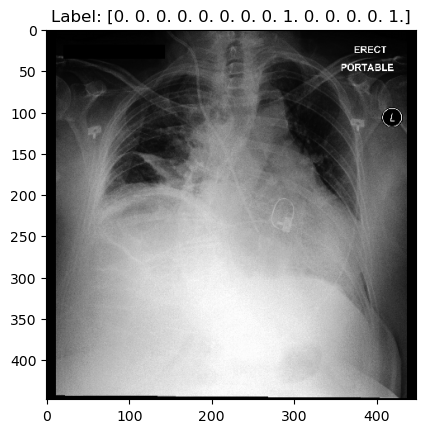

patient: tf.Tensor([b'19631417' b'57519417' b'81562165-d9b54bf7-d9c18f74-a6dcce5b-652c9940'], shape=(3,), dtype=string)


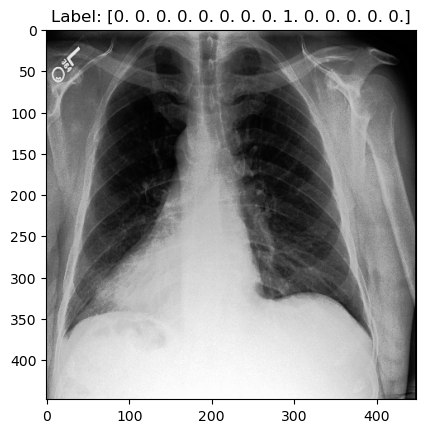

patient: tf.Tensor([b'13040858' b'58103787' b'7f24b0e2-0116a559-14268420-1f924082-0e76bddc'], shape=(3,), dtype=string)


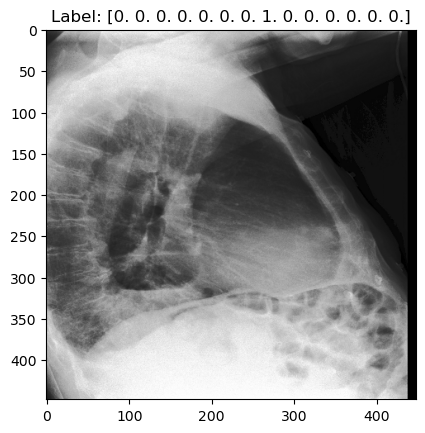

patient: tf.Tensor([b'16522952' b'50740255' b'37ddc5f9-05ccc32f-1892009b-abe07796-6d6b4e59'], shape=(3,), dtype=string)


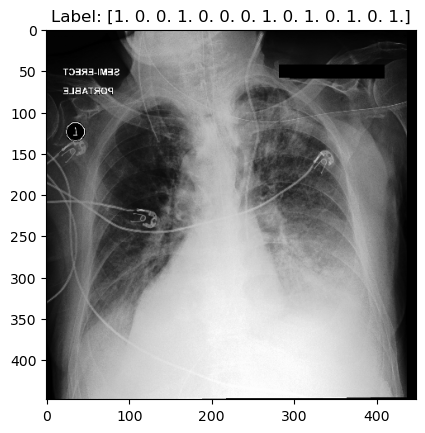

patient: tf.Tensor([b'13611526' b'59990335' b'fc69aa27-504a1260-dbb6fdef-98648e8e-bf572519'], shape=(3,), dtype=string)


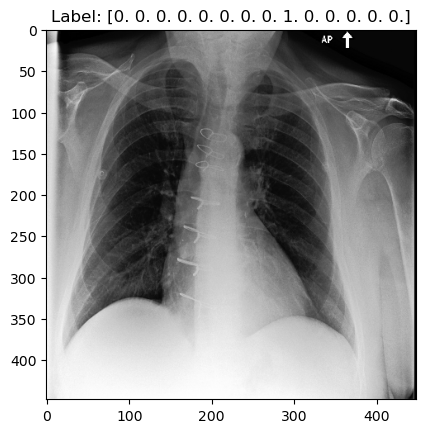

patient: tf.Tensor([b'19780933' b'52632163' b'1e692140-db6fb413-2fa719f2-b9baa533-40f21b32'], shape=(3,), dtype=string)


In [5]:
import matplotlib.pyplot as plt
# batch = tf.data.make_one_shot_iterator(x).get_next()
# Visualize image
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = batched_train_tfds.prefetch(buffer_size=AUTOTUNE)

# Visualize the images and labels from the batch
# for batch in train_ds.take(1):
for batch in train_ds.take(1):
    for i in range(len(batch['image'])):
        image = batch['image'][i]
        label = batch['label'][i]
        info = batch['info'][i]

        # Convert TensorFlow tensors to NumPy arrays
        # image_array = image.squeeze()  # If necessary, remove singleton dimensions
        # label_array = label

        # Display the image and label
        plt.imshow(image, cmap='gray')  # Assuming grayscale images
        plt.title(f"Label: {label}")
        plt.show()
        print('patient:', info)

In [3]:
import matplotlib.pyplot as plt

batch = tf.data.make_one_shot_iterator(x).get_next()
# Visualize image
with tf.Session() as sess:
    # Get the next batch
    # sess.run(tf.global_variables_initializer())
    batch = sess.run(batch)

    # Visualize the images and labels from the batch
    for i in range(len(batch['image'])):
        image = batch['image'][i]
        label = batch['label'][i]
        info = batch['info'][i]

        # Convert TensorFlow tensors to NumPy arrays
        image_array = image.squeeze()  # If necessary, remove singleton dimensions
        label_array = label

        # Display the image and label
        plt.imshow(image_array, cmap='gray')  # Assuming grayscale images
        plt.title(f"Label: {label_array}")
        plt.show()
        print('patient:', info)

RuntimeError: The Session graph is empty. Add operations to the graph before calling run().

In [1]:
import tensorflow as tf

# Example dataset creation
dataset = tf.data.Dataset.range(10)  # Creating a simple dataset of integers from 0 to 9

# Specify the index of the sample you want to retrieve
sample_index = 3

# Skip the samples before the desired index
dataset = dataset.skip(sample_index)

# Take only the next sample after skipping
desired_sample = dataset.take(1)

# Iterate over the dataset to retrieve the desired sample
for sample in desired_sample:
    print(sample.numpy())

2024-01-17 10:13:06.365550: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


3


In [11]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [4]:
# Fetch batches in the background while the model is training.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = x.prefetch(buffer_size=AUTOTUNE)
# train_ds = tf.data.make_one_shot_iterator(x).get_next()
for batch in train_ds.take(1):
    print("Shape of features array:", batch['image'].numpy().shape)
    print("Shape of labels array:", batch['label'].numpy().shape)

Shape of features array: (5, 448, 448, 3)
Shape of labels array: (5, 14)
